**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [31]:
from scipy.spatial.distance import cdist

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.preprocessing import StandardScaler

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [32]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski', scaler=None):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.scaler = scaler

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        # стандартизация
        if self.scaler:
            X_train = self.scaler.fit_transform(self.X)
            X_test = self.scaler.transform(X)
        else:
            X_train = self.X
            X_test = X

        if self.algorithm == 'brute':

            pairwise_dists = pairwise_distances(X_test, X_train, metric=self.metric) # находим расстояния от 
                                                                                     # каждого объекта из предсказываемых
                                                                                     # до каждого из имеющихся
            
            # находим ближайших к каждому объекту соседей
            nearest_indices = np.argpartition(pairwise_dists, self.n_neighbors, axis=1)[:,:self.n_neighbors]

        if self.algorithm == 'kd_tree':
            neighbors_tree = KDTree(X_train) # формируем дерево представления соседей

            _, nearest_indices = neighbors_tree.query(X_test, self.n_neighbors) # находим ближайших соседей и их индексы


        nearest_classes = self.y[nearest_indices] # находим классы ближайших соседей
        
        # находим, какие классы встречаются чаще для каждого объекта
        predicted_classes = np.apply_along_axis(lambda obj_nearest_clss: 
                                                np.argmax(np.bincount(obj_nearest_clss)), 
                                                axis=1, arr=nearest_classes)
        return predicted_classes

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [33]:
iris = datasets.load_iris()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [35]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [36]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [37]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)

In [38]:
accuracy_score(y_test, my_clf_pred)

0.8666666666666667

In [39]:
accuracy_score(y_test, sklearn_pred) 

0.8666666666666667

In [40]:
assert abs(accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [41]:
%time clf.fit(X_train, y_train)

CPU times: user 579 µs, sys: 25 µs, total: 604 µs
Wall time: 614 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [42]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [43]:
%time clf.predict(X_test)

CPU times: user 2.16 ms, sys: 753 µs, total: 2.91 ms
Wall time: 2.35 ms


array([2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0])

In [44]:
%time my_clf.predict(X_test)

CPU times: user 812 µs, sys: 7 µs, total: 819 µs
Wall time: 825 µs


array([2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [45]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [47]:
%time clf.fit(X_train, y_train)

CPU times: user 877 µs, sys: 708 µs, total: 1.58 ms
Wall time: 4.51 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [48]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [49]:
%time clf.predict(X_test)

CPU times: user 2.24 ms, sys: 1.12 ms, total: 3.35 ms
Wall time: 2.65 ms


array([0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 0, 1])

In [50]:
%time my_clf.predict(X_test)

CPU times: user 787 µs, sys: 94 µs, total: 881 µs
Wall time: 834 µs


array([0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 0, 1])

In [51]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)

In [52]:
accuracy_score(y_test, my_clf_pred)

0.9333333333333333

In [53]:
accuracy_score(y_test, sklearn_pred)

0.9333333333333333

In [54]:
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [55]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [56]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [57]:
min_df = 0.01 # 0.8 для подготовки

In [58]:
def prep_subplot(fig, position):
    fig.add_subplot(position)
    plt.ylabel('cross-val-score')
    plt.xlabel('Neighbors amount')

In [60]:
def FindBestKNN(X, y, metric='minkowski', scaler=StandardScaler()):
    res = 0
    ind = 0
    all_scores = []
    for i in range(1, 53, 3):
        clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='brute', metric=metric, scaler=scaler)
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
        mean_score = np.mean(scores)
        all_scores.append(mean_score)
        if mean_score > res:
            res = mean_score
            ind = i
    plt.xticks(range(1, 53, 3))
    plt.plot(range(1, 53, 3), all_scores)
    return ind, res

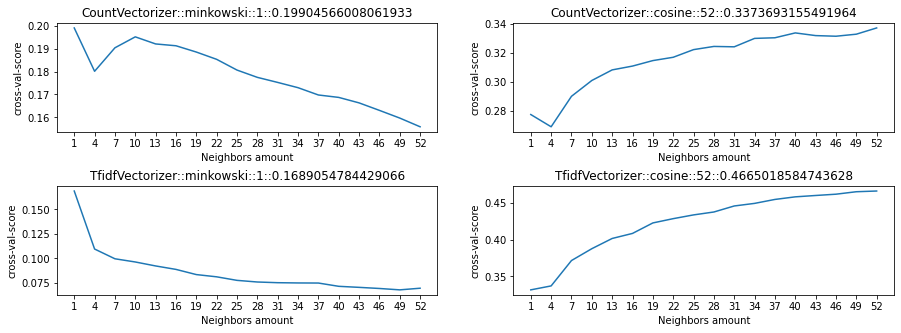

In [504]:
fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
num = 220
for vectorizer in [CountVectorizer, TfidfVectorizer]:
    X = vectorizer(min_df=min_df).fit_transform(data)
    for metric in ['minkowski', 'cosine']:
        if metric == 'minkowski':
            X_data = X.toarray()
            scaler = StandardScaler()
        else:
            X_data = X
            scaler = StandardScaler(with_mean=False)
        num += 1
        prep_subplot(fig, num)
        k, score = FindBestKNN(X_data, target, metric, scaler)
        plt.title('::'.join((str(vectorizer).split('.')[-1][:-2], metric, str(k), str(score))))
plt.show()

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [65]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [66]:
test_data = newsgroups_test['data']
test_target = newsgroups_test['target']

In [67]:
tfidf_vectorizer = TfidfVectorizer(min_df = min_df)
X_tfidf = tfidf_vectorizer.fit_transform(data)

In [68]:
X_test = tfidf_vectorizer.transform(test_data)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [72]:
my_clf = MyKNeighborsClassifier(n_neighbors=52, algorithm='brute', metric='cosine', scaler=StandardScaler(with_mean=False))
my_clf.fit(X_tfidf, target)
accuracy_score(test_target, my_clf.predict(X_test))

0.4206054168879448

In [70]:
expert_clf = KNeighborsClassifier(n_neighbors=52, algorithm='brute', metric='cosine')
expert_clf.fit(X_tfidf, target)
accuracy_score(test_target, expert_clf.predict(X_test))

0.3628518321826872

Лучшая модель получилась при cosine метрике с TfidfVectorizer. Первая всегда работала еще и быстрее. Явно видно, что рост, предположительно, продолжается и дальше 52-ух соседей, но остановимся на этом, так как это уже сильно больше 10.

Тестовый результат: 0.4206054168879448
Результат кросс-валидации: 0.4665018584743628

Качество отличается из-за того, что на кросс-валидации мы все еще не видим тестовых данных. То есть вид тренировочных данных может более сильно отличаться от тестовых, чем каждый фолд отличается от других на кросс-валидации.